# Texture and hyperchromatic areas feature exploration

In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import flood_fill
from skimage import io, color, exposure, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans, MeanShift
from skimage.measure import label, regionprops

In [2]:
#Uncomment to install dependecy
#!pip install opencv-python 

In [3]:
#pip install scikit-image

### Declare variables and lists

In [3]:
# Images root directorie
data_dir = "cancerSeno_bw/train"

# Class list
classes = ["sano", "cancer"]

# Define angles and distanxes for GLCM (Gray-Level Co-Occurrence Matrix)
angles = [0]
distances = [1]

# Define normalization threshold
treshold = 120

# Define max number of clusters for segmentation
max_clusters = 5

# Initialize lists
# Store texture and density of pixels characteristics
glcm_features = []
densidades_pixeles_oscuros = []
num_cúmulos = []

# Store coordinates of origins in clusters
cluster_seeds = []

# Store loaded images
loaded_images = []

### Obtain images from directories

In [4]:
# Iterate over classes
for cls in classes:
    # Obtain route from current directory
    class_dir = os.path.join(data_dir, cls)
    
    # Obtain list of image files from directory
    file_list = os.listdir(class_dir)
    
    # Store the first 3 images from current class
    selected_images = [os.path.join(class_dir, image_name) for image_name in file_list[:3]]
    
    # Add image paths to the loaded-images list
    loaded_images.extend(selected_images)

In [6]:
# Print loaded images paths
print("Nombres de las imágenes cargadas:")
for image_path in loaded_images:
    print(os.path.basename(image_path))

Nombres de las imágenes cargadas:
13024_idx5_x1501_y1351_class0.png
12750_idx5_x1301_y1451_class0.png
14305_idx5_x1901_y951_class0.png
9177_idx5_x1101_y2051_class1.png
12822_idx5_x601_y351_class1.png
12897_idx5_x1401_y1301_class1.png


#### Density histogram

In [7]:
def density_histogram(image):  

    # Normalize image
    imagen_normalizada = image / 255.0
            
    # Calculate image intensity range
    min_intensity = np.min(image)
    max_intensity = np.max(image)
            
    # Calculate intensity histogram for image with adjusted bins
    histogram = np.histogram(image, bins=np.arange(min_intensity, max_intensity+1), range=(min_intensity, max_intensity))[0]
   
    # Show histogram
    plt.plot(histogram)
    plt.title('Histograma de Intensidad de la Imagen')
    plt.xlabel('Intensidad')
    plt.ylabel('Frecuencia')
    plt.show()

13024_idx5_x1501_y1351_class0.png


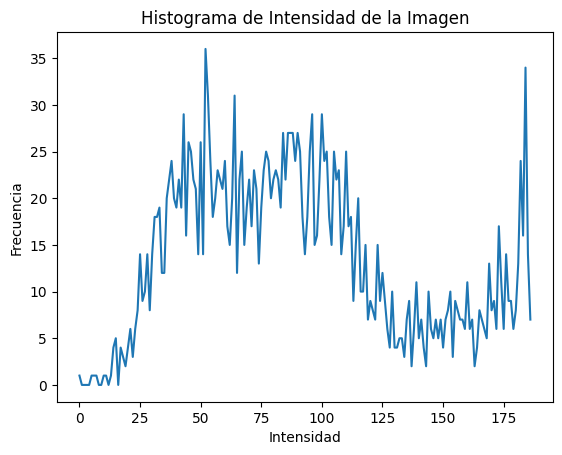

12750_idx5_x1301_y1451_class0.png


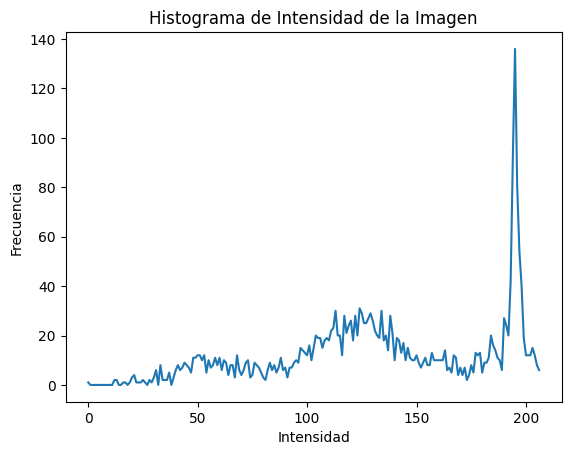

14305_idx5_x1901_y951_class0.png


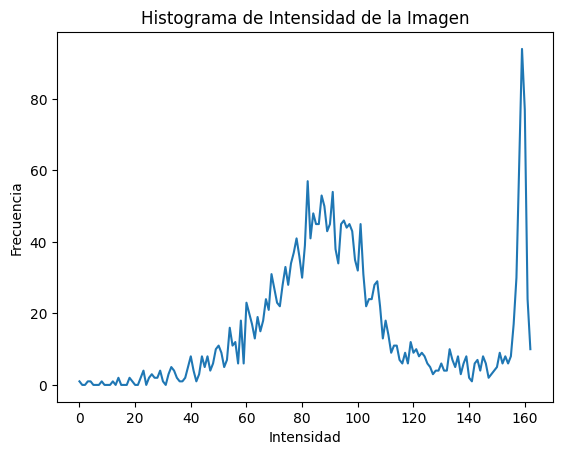

9177_idx5_x1101_y2051_class1.png


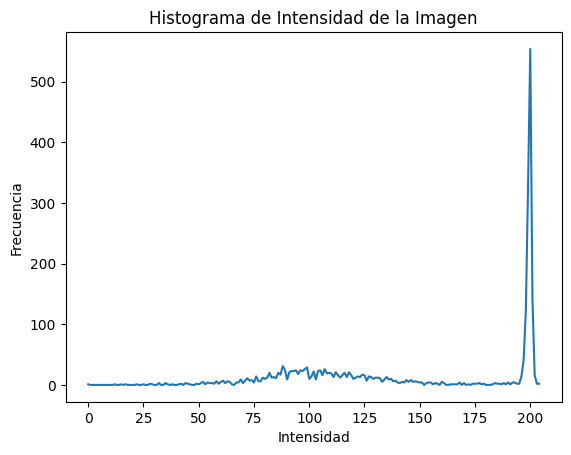

12822_idx5_x601_y351_class1.png


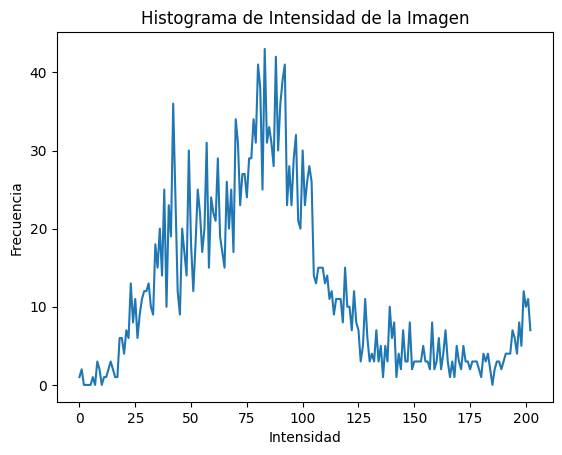

12897_idx5_x1401_y1301_class1.png


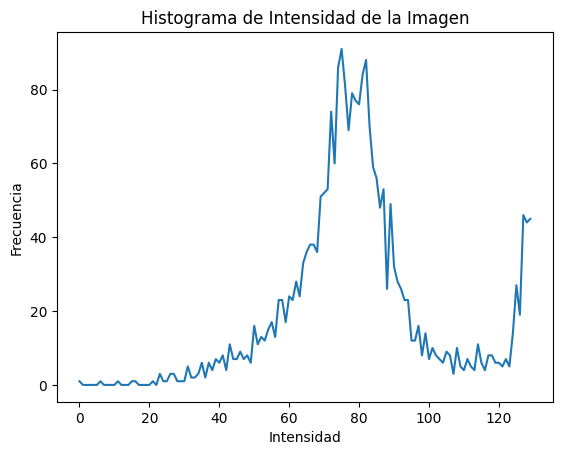

In [8]:
for image_path in loaded_images:
    print(os.path.basename(image_path))
    gray_image = io.imread(image_path)
    density_histogram(gray_image)

#### GLCM Matrix

In [9]:
def calculate_glcm(image):
    
    # Normalize image
    normalized_image = gray_image / 255.0
    
    # Define GLCM parameters
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    # Transform image into unsigned int
    gray_image_uint8 = np.uint8(normalized_image * 255)
    
    # Calculate GLCM
    glcm = graycomatrix(gray_image_uint8, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    # Calculate GLCM properties
    properties = ['contrast', 'correlation', 'energy', 'homogeneity']
    glcm_features = []
    for prop in properties:
        glcm_features.append(graycoprops(glcm, prop))
    
    # Print texture characteristics
    print("Propiedades de la GLCM:")
    for i, prop in enumerate(properties):
        print(f"{prop}: {glcm_features[i]}")
    print("***")
    return glcm

In [10]:
for image_path in loaded_images:
    print(os.path.basename(image_path))
    gray_image = io.imread(image_path)
    calculate_glcm(gray_image)

13024_idx5_x1501_y1351_class0.png
Propiedades de la GLCM:
contrast: [[1135.06530612 1690.8729696  1160.31714286 1676.00124948]]
correlation: [[0.71012328 0.57234962 0.70430087 0.57608223]]
energy: [[0.01801707 0.01740822 0.01816212 0.01769483]]
homogeneity: [[0.06204584 0.05322035 0.06369225 0.05685893]]
***
12750_idx5_x1301_y1451_class0.png
Propiedades de la GLCM:
contrast: [[ 747.28653061 1177.02832153 1119.71102041 1571.86797168]]
correlation: [[0.84074959 0.7488476  0.76184152 0.66471001]]
energy: [[0.03645586 0.03611142 0.03741212 0.03434617]]
homogeneity: [[0.14062849 0.13411121 0.14879749 0.11409594]]
***
14305_idx5_x1901_y951_class0.png
Propiedades de la GLCM:
contrast: [[542.93673469 536.77176177 361.61836735 774.29487713]]
correlation: [[0.74533532 0.74897766 0.8300404  0.6376468 ]]
energy: [[0.03118912 0.02949612 0.03090877 0.02868063]]
homogeneity: [[0.12113973 0.11317527 0.12460111 0.09933356]]
***
9177_idx5_x1101_y2051_class1.png
Propiedades de la GLCM:
contrast: [[469.36

#### Pixel density

In [11]:
def dark_pixel_density(image, treshold):
    # Apply thresholding to identify hyperchromatic areas
    _, binary_image = cv2.threshold(image, treshold, 255, cv2.THRESH_BINARY)

    # Calculte the amount of dark pixeles within the hyperchromatic area
    dark_pixels_count = np.sum(binary_image == 0)

    # Calculate the total area of the hyperchromatic areas
    total_area = np.sum(binary_image == 255)

    # Calculate the density of the dark pixels
    dark_pixels_density = dark_pixels_count / total_area

    print(f"Densidad de píxeles oscuros en áreas hipercromáticas: {dark_pixels_density}")
    
    return dark_pixels_density

13024_idx5_x1501_y1351_class0.png
Densidad de píxeles oscuros en áreas hipercromáticas: 0.5772870662460567


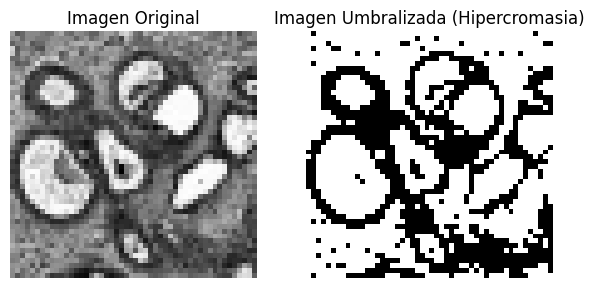

12750_idx5_x1301_y1451_class0.png
Densidad de píxeles oscuros en áreas hipercromáticas: 0.17096018735362997


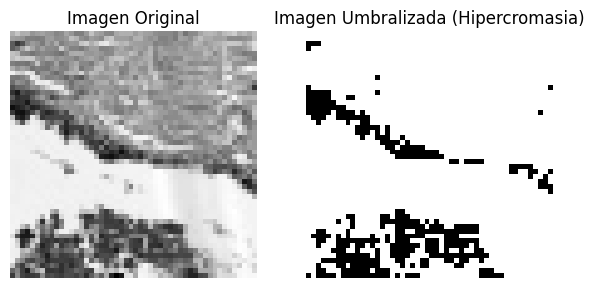

14305_idx5_x1901_y951_class0.png
Densidad de píxeles oscuros en áreas hipercromáticas: 0.028383381324557796


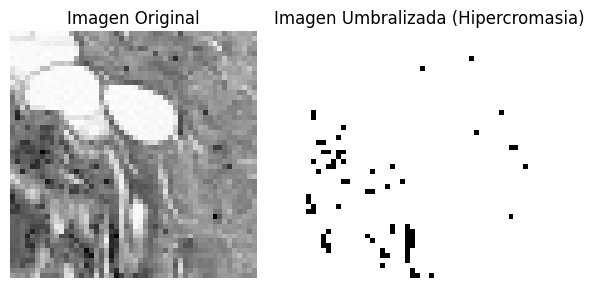

9177_idx5_x1101_y2051_class1.png
Densidad de píxeles oscuros en áreas hipercromáticas: 0.07758620689655173


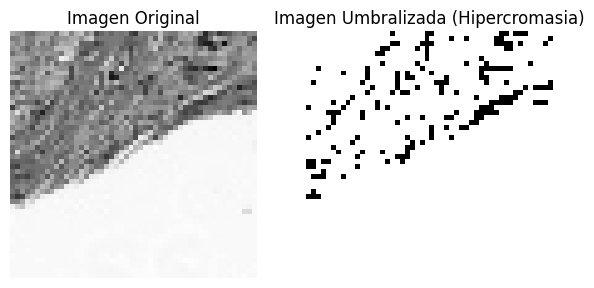

12822_idx5_x601_y351_class1.png
Densidad de píxeles oscuros en áreas hipercromáticas: 1.5329280648429584


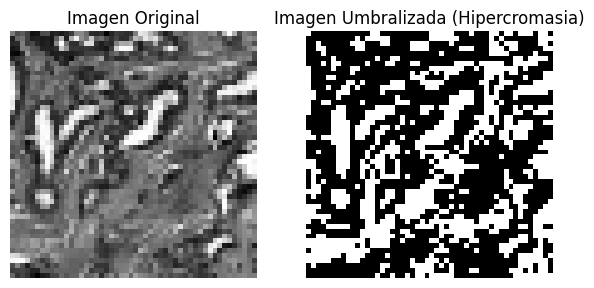

12897_idx5_x1401_y1301_class1.png
Densidad de píxeles oscuros en áreas hipercromáticas: 0.0008006405124099279


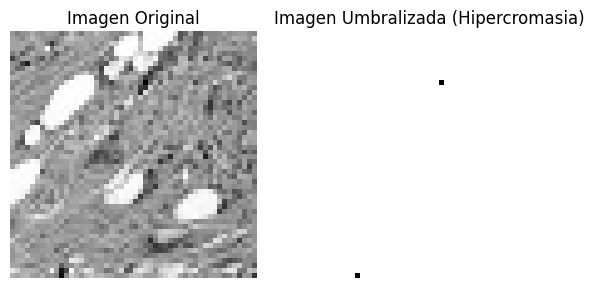

In [12]:
for image_path in loaded_images:
    print(os.path.basename(image_path))
    gray_image = io.imread(image_path)
    
    dpd = dark_pixel_density(gray_image, treshold)

    #Obtain binary image
    _, binary_image = cv2.threshold(gray_image, treshold, 255, cv2.THRESH_BINARY)
    
    # Configure sub grapghics so they are shown side by side
    fig, axs = plt.subplots(1, 2, figsize=(7, 7))

    # Show original image
    axs[0].imshow(gray_image, cmap='gray')
    axs[0].set_title('Imagen Original')
    axs[0].axis('off')

    # Show treholded image
    axs[1].imshow(binary_image, cmap='gray')
    axs[1].set_title('Imagen Umbralizada (Hipercromasia)')
    axs[1].axis('off')

    plt.show()
    

#### Hipercomatic zones or clusters

In [6]:
def encontrar_cumulos(imagen):
    # Etiquetar regiones conectadas
    etiquetas = label(imagen)
    
    # Obtener propiedades de las regiones etiquetadas
    propiedades = regionprops(etiquetas)
    
    # Contar el número de cúmulos y almacenar sus coordenadas
    num_cumulos = len(propiedades)
    coordenadas_cumulos = [(prop.centroid[0], prop.centroid[1]) for prop in propiedades]
    
    return num_cumulos, coordenadas_cumulos

In [7]:
for image_path in loaded_images:
    print(os.path.basename(image_path))
    gray_image = io.imread(image_path)
    num_cumulos, coordenadas_cumulos = encontrar_cumulos(gray_image)
    print("Número de cúmulos:", num_cumulos)
    print("Coordenadas de los cúmulos:", coordenadas_cumulos)

10253_idx5_x1001_y1001_class0.png
Número de cúmulos: 2265
Coordenadas de los cúmulos: [(0.0, 0.0), (0.0, 1.0), (0.0, 2.0), (0.0, 3.0), (0.0, 4.0), (0.0, 5.0), (0.0, 6.0), (0.0, 7.0), (0.0, 8.0), (0.0, 9.0), (0.0, 10.0), (0.0, 11.0), (0.0, 12.0), (0.0, 13.0), (0.0, 14.0), (0.0, 15.0), (0.0, 16.0), (0.0, 17.0), (0.5, 18.5), (0.0, 19.0), (0.0, 20.0), (0.0, 21.0), (0.0, 22.0), (0.0, 23.0), (0.0, 24.0), (0.0, 25.0), (0.0, 26.0), (0.0, 27.0), (0.0, 28.0), (0.0, 29.0), (0.0, 30.0), (0.0, 31.0), (0.0, 32.0), (0.0, 33.0), (0.5, 34.5), (0.0, 35.0), (0.5, 36.0), (0.0, 37.0), (0.0, 38.0), (0.0, 39.0), (0.0, 40.0), (0.0, 41.0), (0.0, 42.0), (0.0, 43.0), (0.5, 44.0), (0.0, 45.0), (0.0, 46.0), (0.0, 47.0), (0.0, 48.0), (0.0, 49.0), (1.0, 0.0), (1.0, 1.0), (1.0, 2.0), (1.0, 3.0), (1.0, 4.0), (1.0, 5.0), (1.0, 6.0), (1.0, 7.0), (1.0, 8.0), (1.0, 9.0), (1.0, 10.0), (1.0, 11.0), (1.0, 12.0), (1.0, 13.0), (1.5, 13.5), (1.0, 15.0), (1.0, 16.0), (1.0, 17.0), (1.0, 18.0), (1.0, 20.0), (1.0, 21.0), (1.0, 22.0